In [1]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [2]:
#@title Import MuJoCo, MJX, and Brax

from datetime import datetime
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Tuple, Union

from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, State
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

In [11]:
#@title State

@struct.dataclass
class State(Base):
  """Environment state for training and inference with brax.

  Args:
    pipeline_state: the physics state, mjx.Data
    obs: environment observations
    reward: environment reward
    done: boolean, True if the current episode has terminated
    metrics: metrics that get tracked per environment step
    info: environment variables defined and updated by the environment reset
      and step functions
  """

  pipeline_state: mjx.Data
  obs: jax.Array
  reward: jax.Array
  done: jax.Array
  metrics: Dict[str, jax.Array] = struct.field(default_factory=dict)
  info: Dict[str, Any] = struct.field(default_factory=dict)

In [12]:
#@title MjxEnv

class MjxEnv(Env):
  """API for driving an MJX system for training and inference in brax."""

  def __init__(
      self,
      mj_model: mujoco.MjModel,
      physics_steps_per_control_step: int = 1,
  ):
    """Initializes MjxEnv.

    Args:
      mj_model: mujoco.MjModel
      physics_steps_per_control_step: the number of times to step the physics
        pipeline for each environment step
    """
    self.model = mj_model
    self.data = mujoco.MjData(mj_model)
    self.sys = mjx.device_put(mj_model)
    self._physics_steps_per_control_step = physics_steps_per_control_step

  def pipeline_init(
      self, qpos: jax.Array, qvel: jax.Array
  ) -> mjx.Data:
    """Initializes the physics state."""
    data = mjx.device_put(self.data)
    data = data.replace(qpos=qpos, qvel=qvel, ctrl=jp.zeros(self.sys.nu))
    data = mjx.forward(self.sys, data)
    return data

  def pipeline_step(
      self, data: mjx.Data, ctrl: jax.Array
  ) -> mjx.Data:
    """Takes a physics step using the physics pipeline."""
    def f(data, _):
      data = data.replace(ctrl=ctrl)
      return (
          mjx.step(self.sys, data),
          None,
      )
    data, _ = jax.lax.scan(f, data, (), self._physics_steps_per_control_step)
    return data

  @property
  def dt(self) -> jax.Array:
    """The timestep used for each env step."""
    return self.sys.opt.timestep * self._physics_steps_per_control_step

  @property
  def observation_size(self) -> int:
    rng = jax.random.PRNGKey(0)
    reset_state = self.unwrapped.reset(rng)
    return reset_state.obs.shape[-1]

  @property
  def action_size(self) -> int:
    return self.sys.nu

  @property
  def backend(self) -> str:
    return 'mjx'

  def _pos_vel(
      self, data: mjx.Data
      ) -> Tuple[Transform, Motion]:
    """Returns 6d spatial transform and 6d velocity for all bodies."""
    x = Transform(pos=data.xpos[1:, :], rot=data.xquat[1:, :])
    cvel = Motion(vel=data.cvel[1:, 3:], ang=data.cvel[1:, :3])
    offset = data.xpos[1:, :] - data.subtree_com[
        self.model.body_rootid[np.arange(1, self.model.nbody)]]
    xd = Transform.create(pos=offset).vmap().do(cvel)
    return x, xd


In [5]:
#@title Humanoid Env

class Humanoid(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/benchmark/model/humanoid'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'humanoid.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    physics_steps_per_control_step = 5
    kwargs['physics_steps_per_control_step'] = kwargs.get(
        'physics_steps_per_control_step', physics_steps_per_control_step)

    super().__init__(mj_model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.qpos[2] < min_z, x=0.0, y=1.0)
    is_healthy = jp.where(
        data.qpos[2] > max_z, x=0.0, y=is_healthy
    )
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

In [6]:
# instantiate the environment
env_name = 'humanoid'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

2024-01-08 14:35:24.691256: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Training a Humanoid Policy

/tmp/ipykernel_181927/3657967982.py:81: DeprecationWarning: Passing condition, x, or y to jax.numpy.where via keyword arguments is deprecated.
  is_healthy = jp.where(data.qpos[2] < min_z, x=0.0, y=1.0)
/tmp/ipykernel_181927/3657967982.py:82: DeprecationWarning: Passing condition, x, or y to jax.numpy.where via keyword arguments is deprecated.
  is_healthy = jp.where(


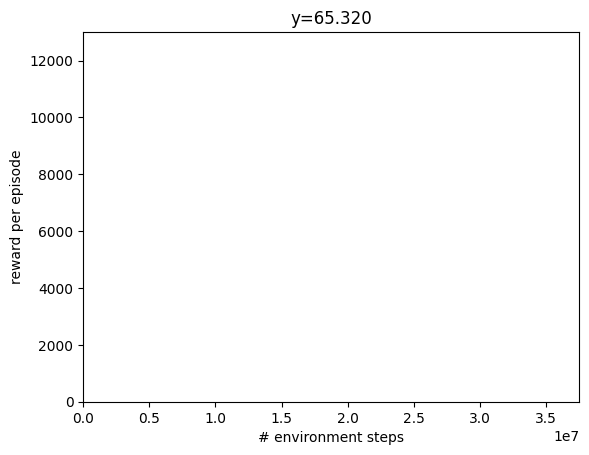

/tmp/ipykernel_181927/3657967982.py:81: DeprecationWarning: Passing condition, x, or y to jax.numpy.where via keyword arguments is deprecated.
  is_healthy = jp.where(data.qpos[2] < min_z, x=0.0, y=1.0)
/tmp/ipykernel_181927/3657967982.py:82: DeprecationWarning: Passing condition, x, or y to jax.numpy.where via keyword arguments is deprecated.
  is_healthy = jp.where(


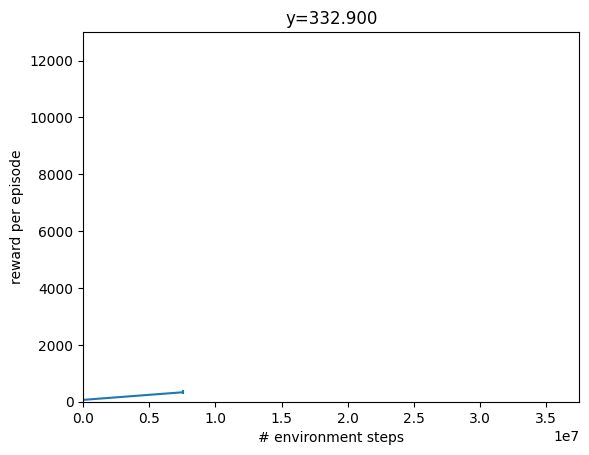

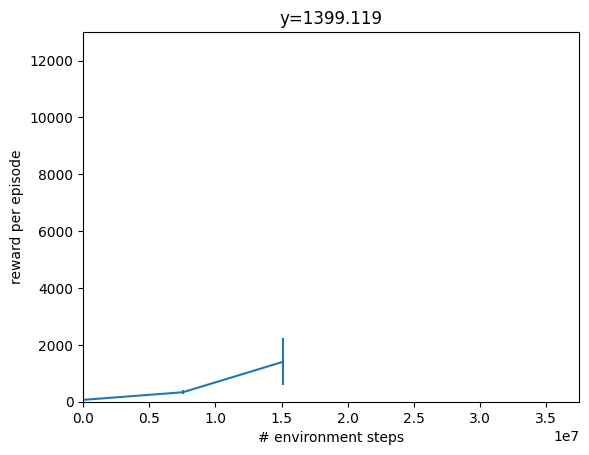

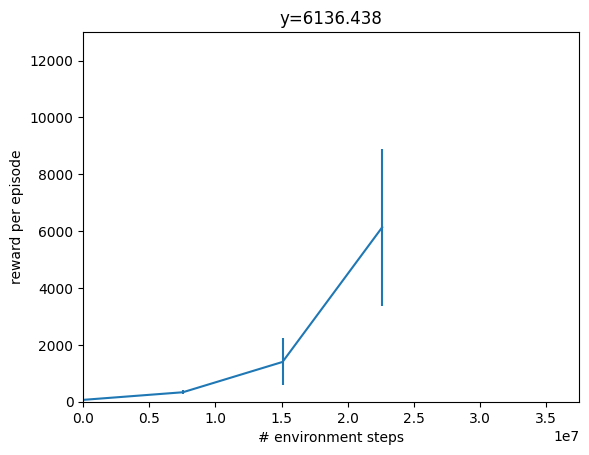

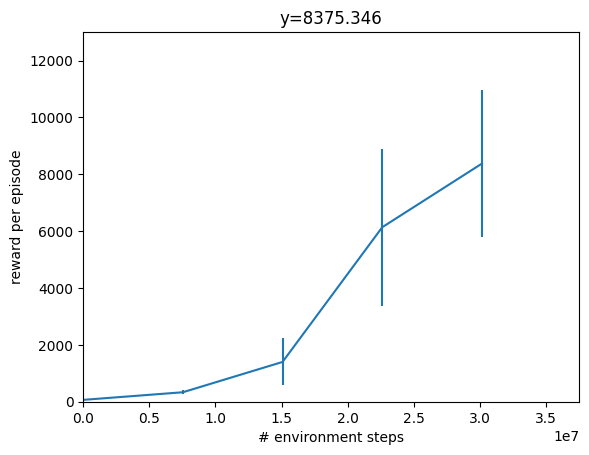

time to jit: 0:00:53.636864
time to train: 0:04:14.815852


In [7]:
train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

# Saving the model

In [13]:
model_path = './models/humandoid_policy'
model.save_params(model_path, params)